In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


2025-05-29 17:46:55.330821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748540815.519017      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748540815.580056      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_dir = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
output_dir = "split_dataset"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create train and test directories
for split_dir in [train_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Split ratio
test_size = 0.1  # 20% for testing

# Iterate through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        images = os.listdir(class_path)
        
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        
        # Create class subdirectories in train and test folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Move files to respective folders
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset split completed successfully!")


Dataset split completed successfully!


In [3]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/train',
    target_size=(250, 250),
    batch_size= 16,
    class_mode = 'categorical'
)
test_datagen = ImageDataGenerator(
    rescale = 1./225
)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/test',
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    shuffle=False 
)

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(250, 250, 3)),

    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(4, activation='softmax')  # Adjust based on number of classes
])

model.summary()
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("model_epoch_{epoch:02d}.keras",  # Save file as 'model_epoch_01.h5', 'model_epoch_02.h5', etc.
                             save_weights_only=False,  # Saves the entire model (architecture + weights)
                             save_freq='epoch',        # Save after every epoch
                             verbose=1)
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping,checkpoint]
)

Found 30585 images belonging to 4 classes.
Found 3399 images belonging to 4 classes.


I0000 00:00:1748541079.752729      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 250, 250, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250, 250, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 31, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 15, 15, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,630,852 (10.04 MB)

 Trainable params: 2,625,796 (10.02 MB)

 Non-trainable params: 5,056 (19.75 KB)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748541088.045743     110 service.cc:148] XLA service 0x792f0401d1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748541088.046657     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748541088.750930     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1912 ━━━━━━━━━━━━━━━━━━━━ 1:01 32ms/step - accuracy: 0.1419 - loss: 2.5830 

I0000 00:00:1748541094.967992     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4219 - loss: 1.5197
Epoch 1: saving model to model_epoch_01.keras
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - accuracy: 0.4220 - loss: 1.5194 - val_accuracy: 0.4672 - val_loss: 1.7064
Epoch 2/30
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6404 - loss: 0.8649
Epoch 2: saving model to model_epoch_02.keras
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.6404 - loss: 0.8648 - val_accuracy: 0.6705 - val_loss: 0.8689
Epoch 3/30
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7918 - loss: 0.5262
Epoch 3: saving model to model_epoch_03.keras
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.7918 - loss: 0.5261 - val_accuracy: 0.5752 - val_loss: 1.8553
Epoch 4/30
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8884 - loss: 0.2937
Epoch 4: saving model to model_epoch_04.keras
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.8884 - loss: 0.2937 - val_accuracy: 0.7846 - val_

In [5]:
saved_model_dir = "/kaggle/working/saved_model_dir"
model.export(saved_model_dir)

# Convert the SavedModel to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")


Saved artifact at '/kaggle/working/saved_model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133246445797200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407115792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407116944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407117328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407116752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407117136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407118096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407118288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133246407114832: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

W0000 00:00:1748543282.274099      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748543282.274139      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748543282.309913      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 250, 250,   3], dtype=int32), 'shape_signature': array([ -1, 250, 250,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 52, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Predicted class index: 0
Predicted class name: Mild Demented


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


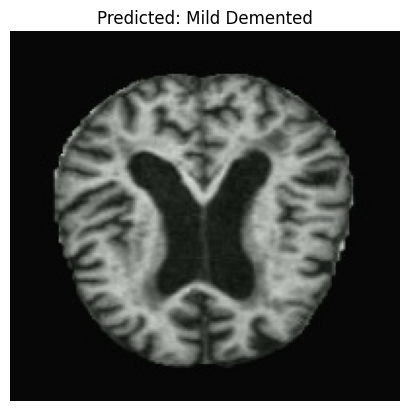

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
tflite_model_path = "/kaggle/working/model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input details:", input_details)
print("Output details:", output_details)

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size=(250, 250)):
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    # Convert to array
    img_array = image.img_to_array(img)
    # Normalize to [0,1]
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array

img_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg"
input_data = load_and_preprocess_image(img_path)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Predicted class index
predicted_class = np.argmax(output_data, axis=1)[0]
print("Predicted class index:", predicted_class)

# Optional: If you have the class labels, map index to class name
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Mild Demented']
print("Predicted class name:", class_labels[predicted_class])

# Display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
